In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import sys
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [3]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0
Number of tweets in training set after cleaning: 69490
Number of tweets in validation set after cleaning: 998
Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [4]:
twitts_train.drop(columns=['tweetID', 'entity'], inplace=True)
twitts_valid.drop(columns=['tweetID', 'entity'], inplace=True)

In [5]:
data = pd.concat([twitts_train, twitts_valid], ignore_index=True)

In [6]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import process_tokenize

In [7]:
x=data.drop('sentiment',axis=1)
y=data.sentiment

texts=list(x['tweet_content'])
cleaned_text = [process_tokenize(text) for text in texts]
print(cleaned_text[:10])

[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

the size of vocab = 20591


In [10]:
maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [11]:
y.value_counts()


sentiment
negative    21432
positive    19342
neutral     17327
Name: count, dtype: int64

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
import numpy as np
D=100
inputt=Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=v + 1, output_dim=D, input_length=maxlen)(inputt)
x = Dropout(0.5)(embedding_layer)
x = LSTM(150)(x)
x = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(x) 
model = Model(inputs=inputt, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     2,059,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,214,731 (8.45 MB)

 Trainable params: 2,214,731 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)
history = model.fit(X_train, y_train_one_hot, epochs=25, validation_data=(X_test, y_test_one_hot))

Epoch 1/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 70s 48ms/step - accuracy: 0.6089 - loss: 0.8285 - val_accuracy: 0.8357 - val_loss: 0.4363
Epoch 2/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - accuracy: 0.8719 - loss: 0.3393 - val_accuracy: 0.8726 - val_loss: 0.3304
Epoch 3/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 72s 49ms/step - accuracy: 0.9124 - loss: 0.2259 - val_accuracy: 0.8948 - val_loss: 0.2858
Epoch 4/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 72s 49ms/step - accuracy: 0.9311 - loss: 0.1740 - val_accuracy: 0.9003 - val_loss: 0.2720
Epoch 5/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 77s 53ms/step - accuracy: 0.9424 - loss: 0.1446 - val_accuracy: 0.9045 - val_loss: 0.2788
Epoch 6/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - accuracy: 0.9468 - loss: 0.1284 - val_accuracy: 0.9089 - val_loss: 0.2713
Epoch 7/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - accuracy: 0.9552 - loss: 0.1106 - val_accuracy: 0.9115 - val_loss: 0.2740
Epoch 8/25
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 77s 53ms/step - accuracy: 0.9587 -

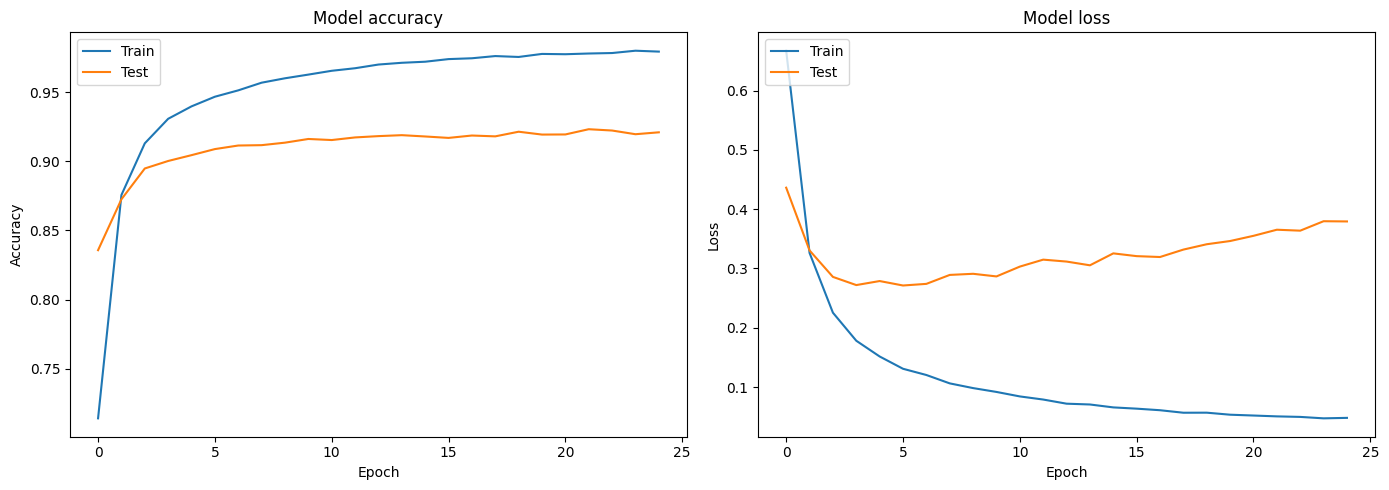

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

364/364 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9231 - loss: 0.3849
Test Loss: 0.3793412446975708
Test Accuracy: 0.9210050702095032


364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


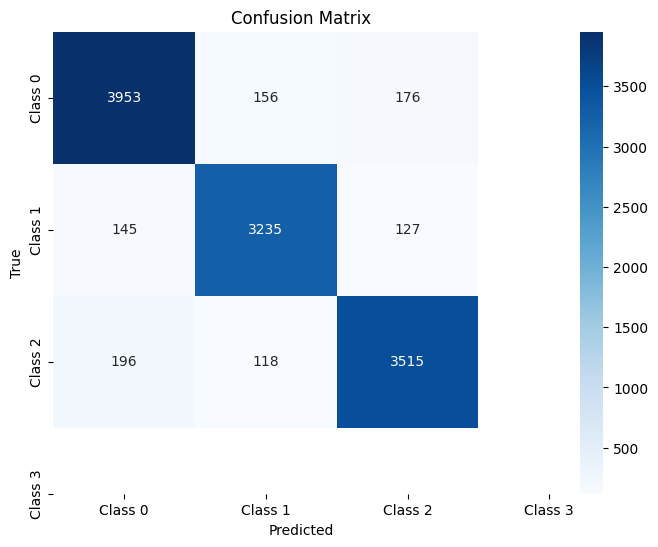

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      4285
     neutral       0.92      0.92      0.92      3507
    positive       0.92      0.92      0.92      3829

    accuracy                           0.92     11621
   macro avg       0.92      0.92      0.92     11621
weighted avg       0.92      0.92      0.92     11621



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# como sei o que representa cada classe?
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))
